In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import chardet
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Loading Data

You can download the dataset from [this link](https://www.unb.ca/cic/datasets/ids-2017.html). I opted to use only the processed data in the CSVs folder instead of the raw packets data, as it allows for more direct investigation and easier insight generation.

To download the data via terminal, use the following command:
```
wget -r -np -nH --cut-dirs=3 -R "index.html*" http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/CIC-IDS-2017/CSVs/
```

In [2]:
# Unzip the data
path = "GeneratedLabelledFlows.zip"
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(".")


In [3]:
# print the files in the directory
print(os.listdir())


['train_nn.ipynb', 'all_data.csv', 'Net.py', 'GeneratedLabelledFlows.md5', 'GeneratedLabelledFlows.zip', 'TrafficLabelling ', 'EDA_Preprocessing_CICCDS2017.ipynb']


Folder 'TrafficLabelling ' was created, now let's see what files are in it:

In [4]:
folder_data = "TrafficLabelling /"
print(os.listdir(folder_data))

['Tuesday-WorkingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv', 'Wednesday-workingHours.pcap_ISCX.csv']


There are 8 CSV files extracted. To facilitate better visualization and preprocessing, combine them into a single dataframe.

While reading the CSVs, one of them (`Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv`) failed due to the following error:

```
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x96 in position 22398: invalid start byte
```

This can be fixed by detecting the encoding for each file and using the correct encoding while reading them into a pandas dataframe.

In [5]:
# Load the data into one dataframe all_data to make it easier to visualize and process

folder_data = "TrafficLabelling /"
all_data = pd.DataFrame()

for file in os.listdir(folder_data):
    if file.endswith(".csv"):
        print("reading file: ", file)

        # Detect encoding
        with open(folder_data + file, 'rb') as f:
            result = chardet.detect(f.read())
            encoding = result['encoding']
        data = pd.read_csv(folder_data + file, encoding=encoding, low_memory=False, skipinitialspace=True)
        all_data = pd.concat([all_data, data])



reading file:  Tuesday-WorkingHours.pcap_ISCX.csv
reading file:  Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
reading file:  Friday-WorkingHours-Morning.pcap_ISCX.csv
reading file:  Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
reading file:  Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
reading file:  Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
reading file:  Monday-WorkingHours.pcap_ISCX.csv
reading file:  Wednesday-workingHours.pcap_ISCX.csv


In [6]:
all_data.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.3-192.168.10.5-88-49182-6,192.168.10.5,49182.0,192.168.10.3,88.0,6.0,4/7/2017 8:54,640.0,7.0,4.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.3-192.168.10.5-88-49183-6,192.168.10.5,49183.0,192.168.10.3,88.0,6.0,4/7/2017 8:54,900.0,9.0,4.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.3-192.168.10.5-88-49184-6,192.168.10.5,49184.0,192.168.10.3,88.0,6.0,4/7/2017 8:54,1205.0,7.0,4.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.3-192.168.10.5-88-49185-6,192.168.10.5,49185.0,192.168.10.3,88.0,6.0,4/7/2017 8:54,511.0,7.0,4.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.3-192.168.10.5-88-49186-6,192.168.10.5,49186.0,192.168.10.3,88.0,6.0,4/7/2017 8:54,773.0,9.0,4.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [7]:
# Save the data to a csv file
all_data.to_csv("all_data.csv", index=False)

## EDA

In [ ]:
# Number of rows and columns
print(f"Number of rows: {all_data.shape[0]}")
print(f"Number of columns: {all_data.shape[1]}")

Number of rows: 3119345
Number of columns: 85


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3119345 entries, 0 to 692702
Data columns (total 85 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Flow ID                       object 
 1    Source IP                    object 
 2    Source Port                  float64
 3    Destination IP               object 
 4    Destination Port             float64
 5    Protocol                     float64
 6    Timestamp                    object 
 7    Flow Duration                float64
 8    Total Fwd Packets            float64
 9    Total Backward Packets       float64
 10  Total Length of Fwd Packets   float64
 11   Total Length of Bwd Packets  float64
 12   Fwd Packet Length Max        float64
 13   Fwd Packet Length Min        float64
 14   Fwd Packet Length Mean       float64
 15   Fwd Packet Length Std        float64
 16  Bwd Packet Length Max         float64
 17   Bwd Packet Length Min        float64
 18   Bwd Packet Length Mean     

### Missing Values

In [ ]:
# Rows that contain olny NaN values
nan_rows = all_data[all_data.isnull().all(axis=1)]
print(f"Number of rows that contain only NaN values: {nan_rows.shape[0]}")

# Drop rows that contain only NaN values
all_data = all_data.dropna(how='all')
print(f"Number of rows after dropping rows that contain only NaN values: {all_data.shape[0]}")

Number of rows that contain only NaN values: 288602
Number of rows after dropping rows that contain only NaN values: 2830743


In [ ]:
# Number of NaN values in each column
nan_values = all_data.isnull().sum()
print(f"Columns with NaN values:\n{nan_values[nan_values > 0]}")

Columns with NaN values:
Flow Bytes/s    1358
dtype: int64


### Label 


The label column provides the classification for each network traffic record, indicating whether the traffic is benign or associated with a specific type of attack.

In [ ]:
# BENIGN (noarmal traffic) VS everything else (attack traffic)
all_data['Label'].apply(lambda x: x=='BENIGN').value_counts(normalize=True)

 Label
True     0.803004
False    0.196996
Name: proportion, dtype: float64

In [ ]:
all_data['Label'].value_counts()

 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack – Brute Force         1507
Web Attack – XSS                  652
Infiltration                       36
Web Attack – Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

### Distribution of Features

In [ ]:
all_data["Flow ID"].nunique()


1085071

<Axes: >

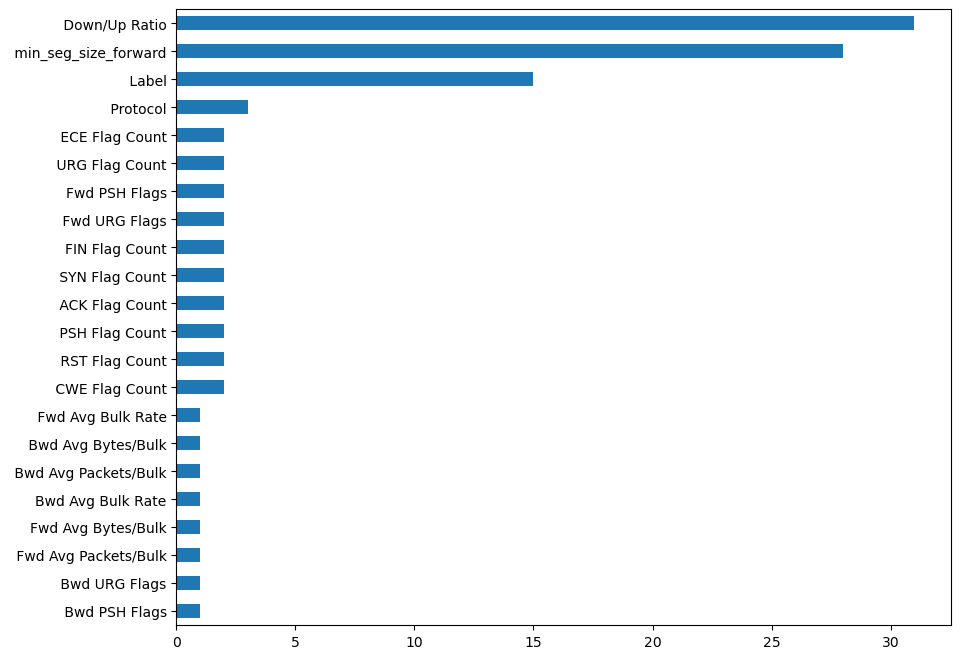

In [ ]:
# Plot number of unique values in each column
unique_values = all_data.nunique()
unique_values[unique_values < 200].sort_values().plot(kind='barh', figsize=(10, 8))

In [ ]:
all_data['Source Port'].value_counts()

 Source Port
443.0      281068
80.0       122817
123.0       23879
137.0        7776
22.0         5084
            ...  
13294.0         1
12989.0         1
30657.0         1
13005.0         1
13426.0         1
Name: count, Length: 64640, dtype: int64

In [ ]:
categorical_columns = all_data.select_dtypes(include=['object']).columns.to_list()
categorical_columns.extend([col for col in all_data.columns if all_data[col].nunique() <= 10])
categorical_columns

['Flow ID',
 ' Source IP',
 ' Destination IP',
 ' Timestamp',
 ' Label',
 ' Protocol',
 'Fwd PSH Flags',
 ' Bwd PSH Flags',
 ' Fwd URG Flags',
 ' Bwd URG Flags',
 'FIN Flag Count',
 ' SYN Flag Count',
 ' RST Flag Count',
 ' PSH Flag Count',
 ' ACK Flag Count',
 ' URG Flag Count',
 ' CWE Flag Count',
 ' ECE Flag Count',
 'Fwd Avg Bytes/Bulk',
 ' Fwd Avg Packets/Bulk',
 ' Fwd Avg Bulk Rate',
 ' Bwd Avg Bytes/Bulk',
 ' Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate']

In [ ]:
numerical_columns = all_data.columns.difference(categorical_columns).to_list()
numerical_columns

[' Active Max',
 ' Active Min',
 ' Active Std',
 ' Average Packet Size',
 ' Avg Bwd Segment Size',
 ' Avg Fwd Segment Size',
 ' Bwd Header Length',
 ' Bwd IAT Max',
 ' Bwd IAT Mean',
 ' Bwd IAT Min',
 ' Bwd IAT Std',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Min',
 ' Bwd Packet Length Std',
 ' Bwd Packets/s',
 ' Destination Port',
 ' Down/Up Ratio',
 ' Flow Duration',
 ' Flow IAT Max',
 ' Flow IAT Mean',
 ' Flow IAT Min',
 ' Flow IAT Std',
 ' Flow Packets/s',
 ' Fwd Header Length',
 ' Fwd Header Length.1',
 ' Fwd IAT Max',
 ' Fwd IAT Mean',
 ' Fwd IAT Min',
 ' Fwd IAT Std',
 ' Fwd Packet Length Max',
 ' Fwd Packet Length Mean',
 ' Fwd Packet Length Min',
 ' Fwd Packet Length Std',
 ' Idle Max',
 ' Idle Min',
 ' Idle Std',
 ' Init_Win_bytes_backward',
 ' Max Packet Length',
 ' Min Packet Length',
 ' Packet Length Mean',
 ' Packet Length Std',
 ' Packet Length Variance',
 ' Source Port',
 ' Subflow Bwd Bytes',
 ' Subflow Bwd Packets',
 ' Subflow Fwd Bytes',
 ' Total Backward Packe

In [ ]:
assert len(categorical_columns) + len(numerical_columns) == all_data.shape[1]

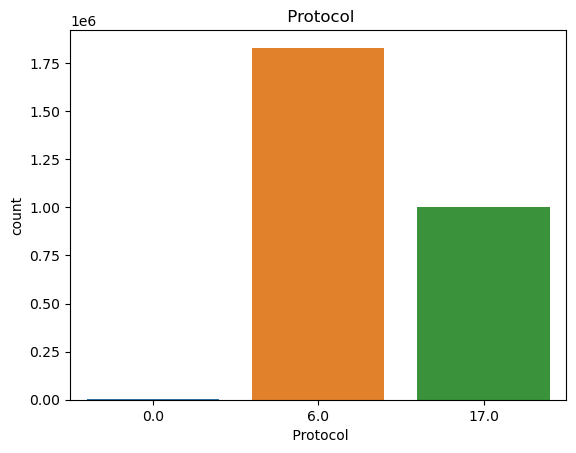

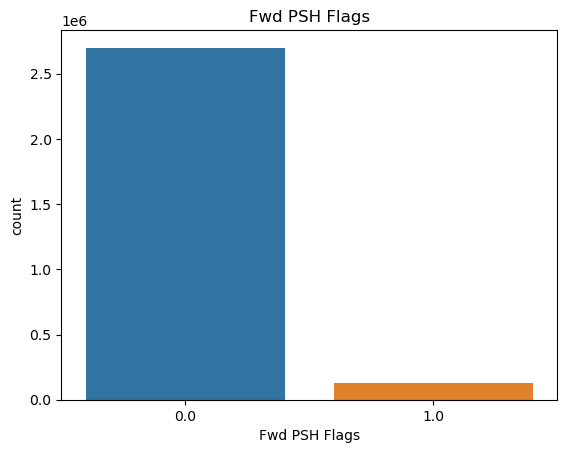

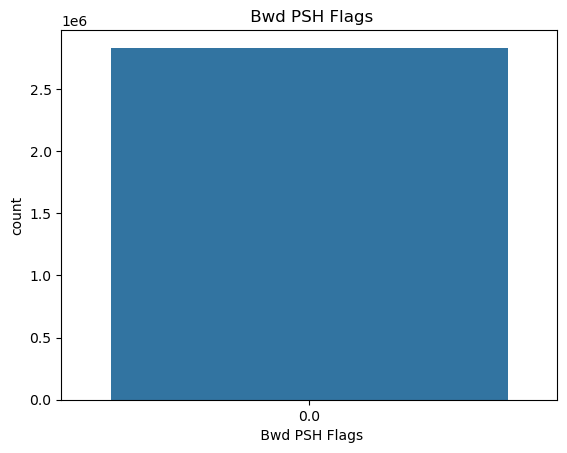

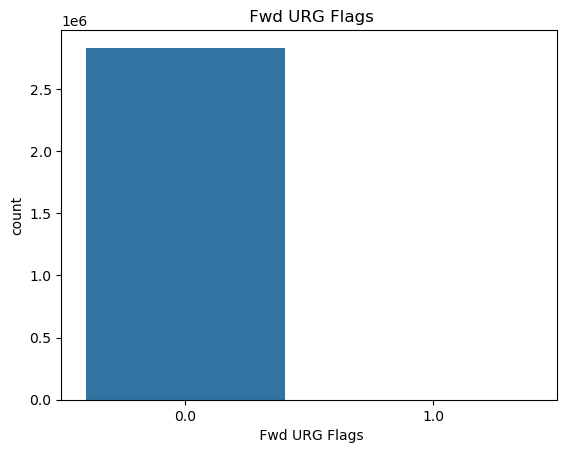

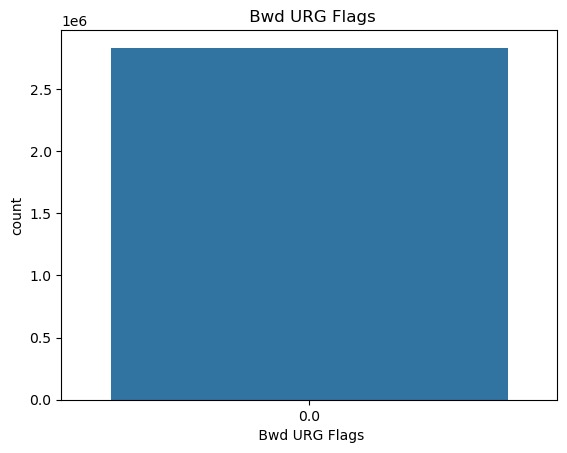

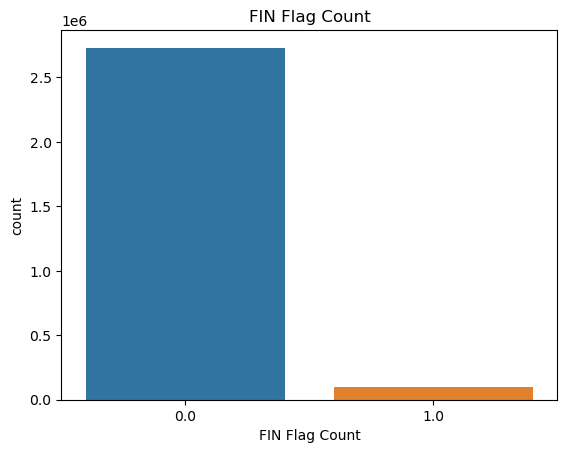

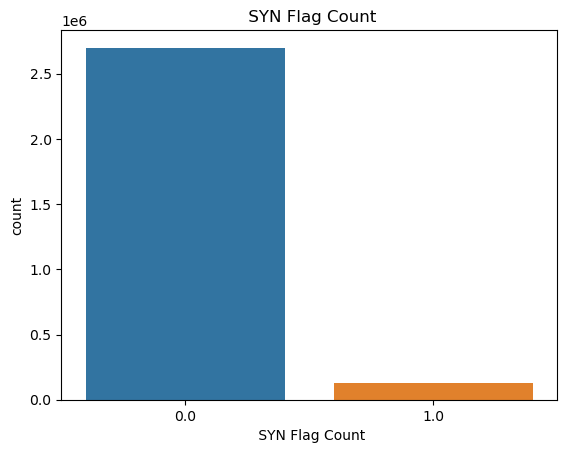

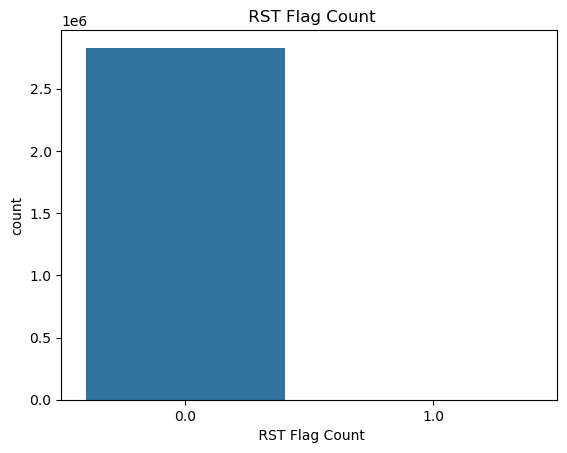

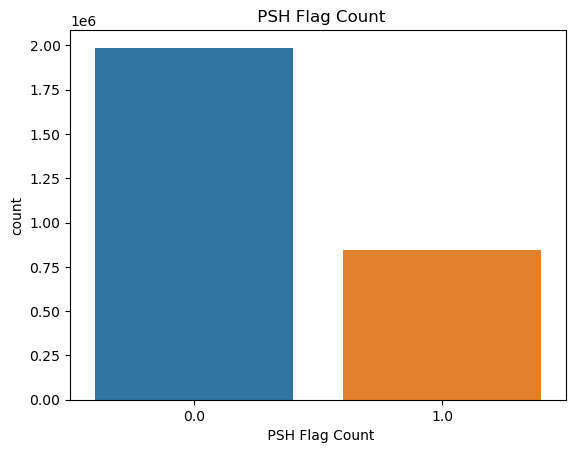

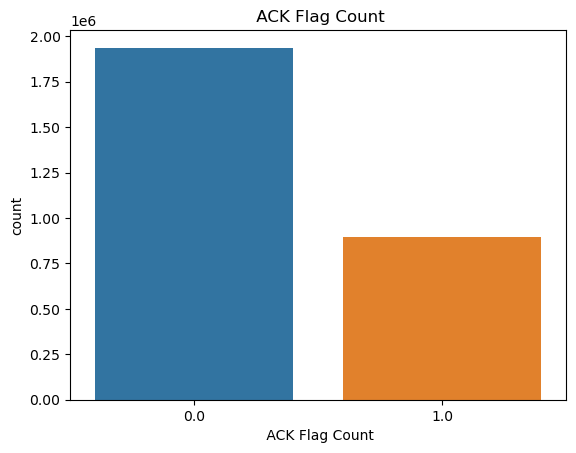

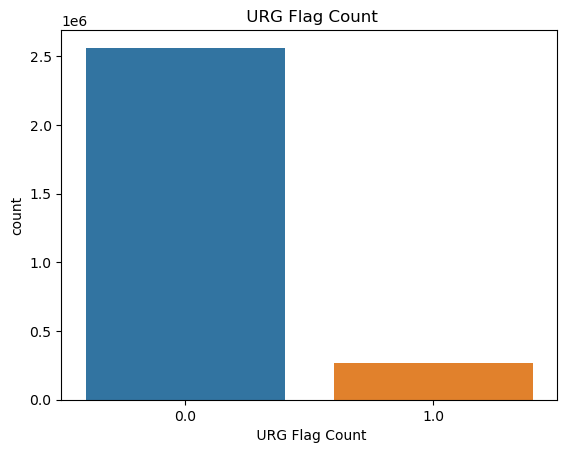

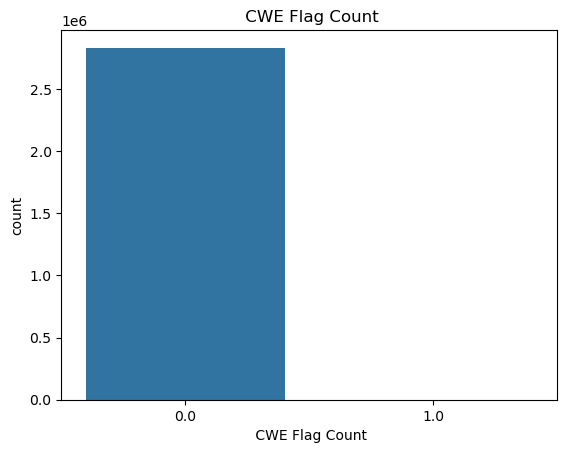

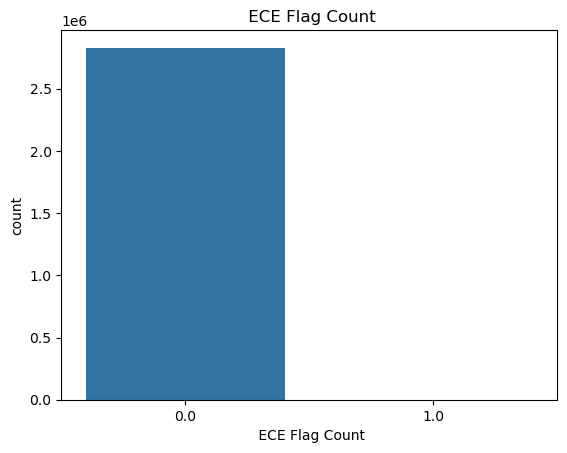

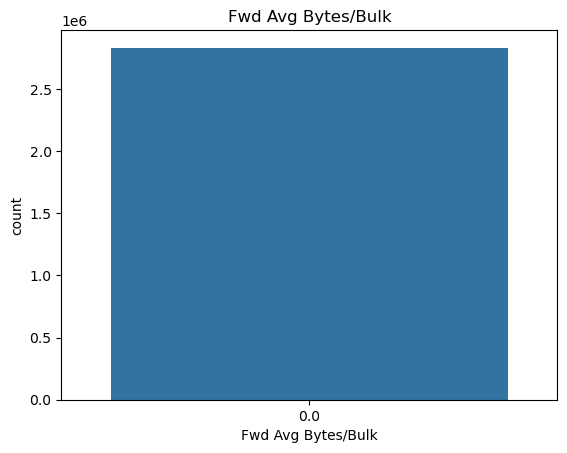

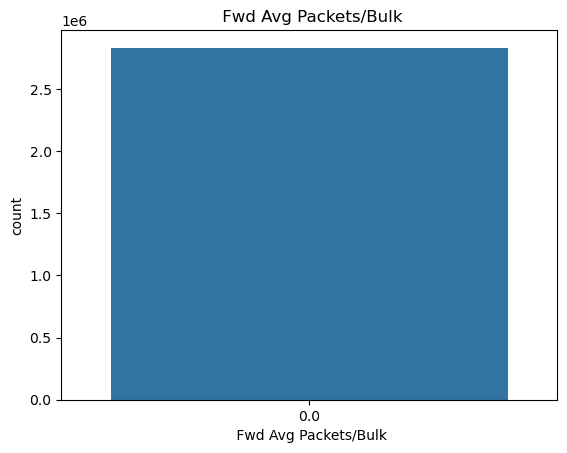

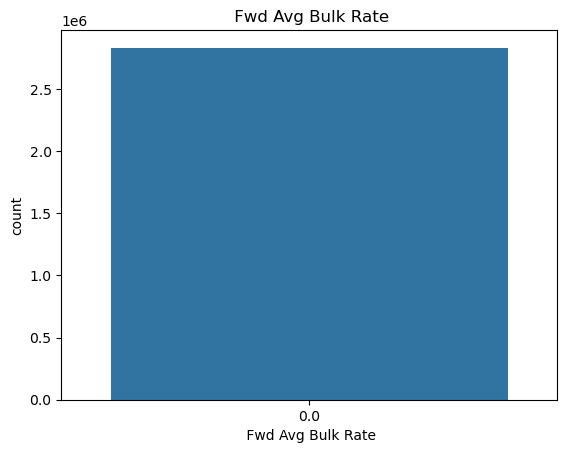

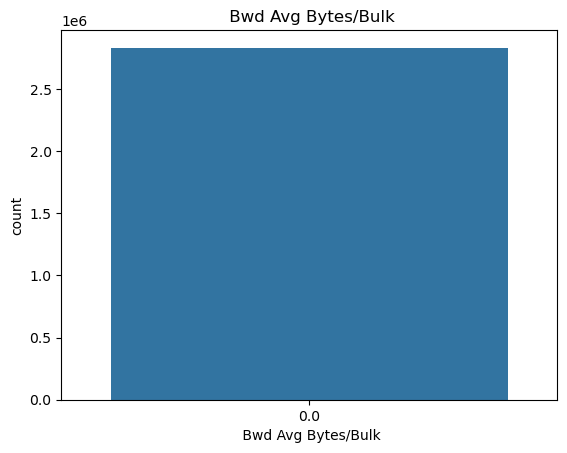

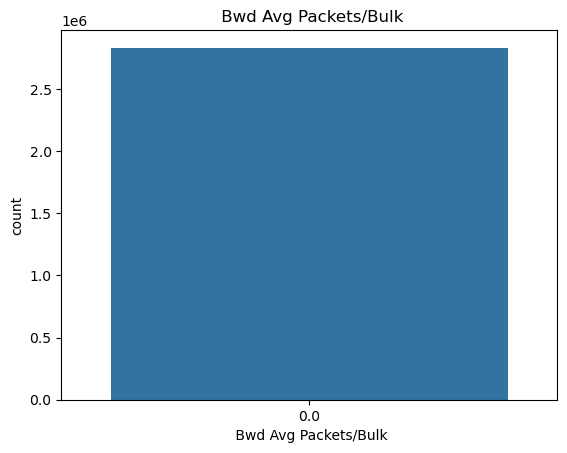

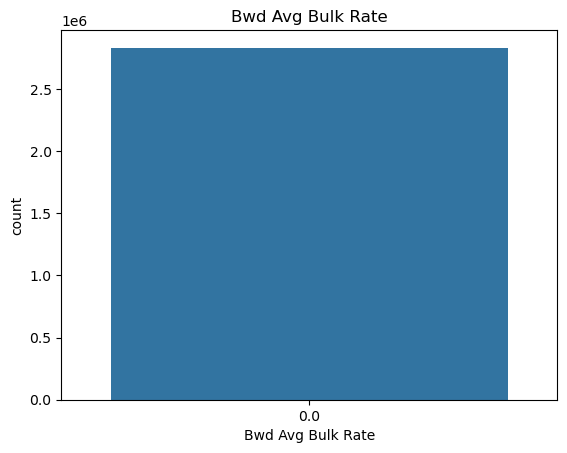

In [ ]:
for col in categorical_columns:
    if all_data[col].nunique() <= 10:
        sns.countplot(x=col, data=all_data)
        plt.title(col)
        plt.show()

    

In [ ]:
# To plot distribution of numerical columns we need to remove NaN and Inf values

# Replace NaN values with mean value of the column "Flow Bytes/s"
all_data['Flow Bytes/s'].fillna(all_data['Flow Bytes/s'].mean(), inplace=True)


In [ ]:
# Replace Inf values with max value of each column
all_data.replace([np.inf, -np.inf], np.nan, inplace=True)
all_data.fillna(all_data.max(), inplace=True)

In [ ]:
def plot_distribution(data, columns, num_cols=4):
    num_rows = len(columns) // num_cols + 1
    plt.figure(figsize=(20, 5 * num_rows))

    for i, col in enumerate(columns):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.histplot(data[col])
        plt.title(col)

    plt.tight_layout()
    plt.show()


/home/lipsker/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lipsker/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lipsker/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lipsker/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

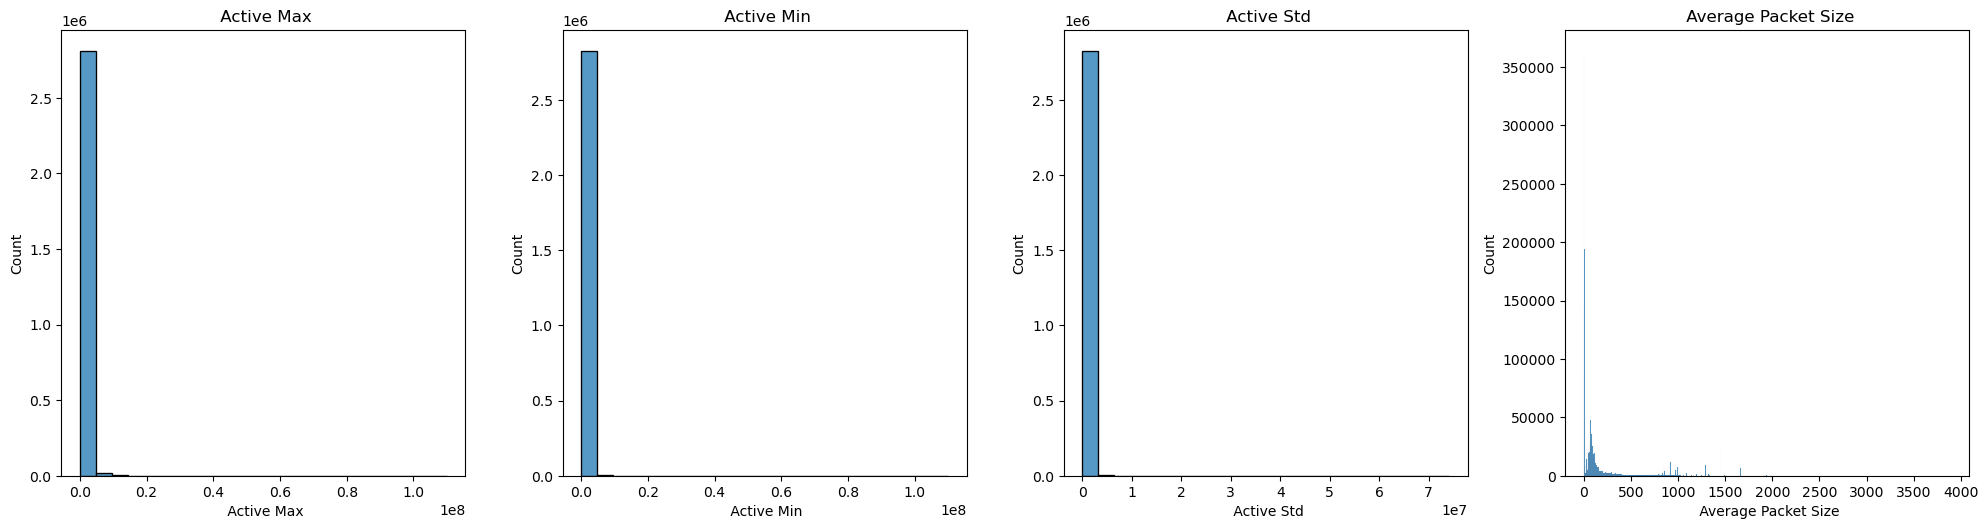

In [ ]:
plot_distribution(all_data, numerical_columns[:4], 4)

## Preprocessing


In [ ]:
all_data.head()


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.3-192.168.10.5-88-49182-6,192.168.10.5,49182.0,192.168.10.3,88.0,6.0,4/7/2017 8:54,640.0,7.0,4.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.3-192.168.10.5-88-49183-6,192.168.10.5,49183.0,192.168.10.3,88.0,6.0,4/7/2017 8:54,900.0,9.0,4.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.3-192.168.10.5-88-49184-6,192.168.10.5,49184.0,192.168.10.3,88.0,6.0,4/7/2017 8:54,1205.0,7.0,4.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.3-192.168.10.5-88-49185-6,192.168.10.5,49185.0,192.168.10.3,88.0,6.0,4/7/2017 8:54,511.0,7.0,4.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.3-192.168.10.5-88-49186-6,192.168.10.5,49186.0,192.168.10.3,88.0,6.0,4/7/2017 8:54,773.0,9.0,4.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [ ]:
# Starting with essential preprocessing

# Dropping columns with only one unique value
columns_to_drop = [col for col in all_data.columns if all_data[col].nunique() == 1]
all_data.drop(columns=columns_to_drop, inplace=True)


### Encoding Labels

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(all_data['Label'])
all_data['Label'] = label_encoder.transform(all_data['Label'])

print(label_encoder.classes_)
all_data['Label'].value_counts()

['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'PortScan'
 'SSH-Patator' 'Web Attack – Brute Force' 'Web Attack – Sql Injection'
 'Web Attack – XSS']


 Label
0     2273097
4      231073
10     158930
2      128027
3       10293
7        7938
11       5897
6        5796
5        5499
1        1966
12       1507
14        652
9          36
13         21
8          11
Name: count, dtype: int64

### Split data

In [ ]:
X = all_data.drop(columns=['Label'])
y = all_data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Enconding Categorical Featueres

In [ ]:
# Protocol column
all_data['Protocol'].value_counts()

 Protocol
6.0     1829554
17.0     999493
0.0        1696
Name: count, dtype: int64

The "Protocol" column is not numeric, meaning the order of its values doesn't matter. For example, protocol 17 is not greater than protocol 6; they are simply different. To prevent misleading an ML model about the nature of this column, I will use one-hot encoding.

In [ ]:
# One hot encoding for the Protocol column
X_train = pd.get_dummies(X_train, columns=['Protocol'])
X_test = pd.get_dummies(X_test, columns=['Protocol'])

X_train.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_0.0,Protocol_6.0,Protocol_17.0
149275,172.16.0.1-192.168.10.50-49830-80-6,172.16.0.1,49830.0,192.168.10.50,80.0,5/7/2017 10:47,99560619.0,6.0,7.0,378.0,...,0.0,10014.0,10014.0,99500000.0,0.0,99500000.0,99500000.0,False,True,False
353642,192.168.10.50-255.255.255.255-42041-3289-17,192.168.10.50,42041.0,255.255.255.255,3289.0,03/07/2017 12:32:05,17.0,13.0,0.0,234.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,True
115309,151.101.210.2-192.168.10.25-443-59438-6,151.101.210.2,443.0,192.168.10.25,59438.0,03/07/2017 11:23:01,64855.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False
432901,192.168.10.5-72.21.91.29-65519-80-6,72.21.91.29,80.0,192.168.10.5,65519.0,03/07/2017 02:43:59,92.0,1.0,1.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False
104390,192.168.10.14-205.174.165.73-51686-8080-6,205.174.165.73,8080.0,192.168.10.14,51686.0,7/7/2017 10:36,38.0,1.0,1.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False


### Droping columns that will not be used for training

If time permits, I will extract meaningful features from these columns


In [ ]:
columns_to_drop = ['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Timestamp']
X_train.drop(columns=columns_to_drop, inplace=True)
X_test.drop(columns=columns_to_drop, inplace=True)

: 

### Scaling
Kernel dies when running this. will try later to solve. 
For Random Forest it dosent metter, nut for nn is dose

In [ ]:
# # scaling the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# Save train and test data
np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

## Train Classical ML model(s)

In [ ]:
### Random Forest Classifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

print(f"Train accuracy: {rf.score(X_train, y_train)}")
print(f"Test accuracy: {rf.score(X_test, y_test)}")

# Feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})") 